#Long-Short Equity Strategies

By Delaney Granizo-Mackenzie

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [https://github.com/quantopian/research_public](https://github.com/quantopian/research_public)



Long-short equity refers to the fact that the strategy is both long and short in the equity market. This is a rather general statement, but has over time grown to mean a specific family of strategies. These strategies rank all stocks in the market using some model. The strategy then goes long (buys) the top $n$ equities of the ranking, and goes short on (sells) the bottom $n$ while maintaining equal dollar volume between the long and short positions. This has the advantage of being statistically robust, as by ranking stocks and entering hundreds or thousands of positions, you are making many bets on your ranking model rather than just a few risky bets. You are also betting purely on the quality of your ranking scheme, as the equal dollar volume long and short positions ensure that the strategy will remain market neutral (immune to market movements).

##Ranking Scheme

A ranking scheme is any model that can assign each stocks a number, where higher is better or worse. Examples could be value factors, technical indicators, pricing models, or a combination of all of the above. The Ranking Universes by Factors lecture will cover ranking schemes in more detail. Ranking schemes are the secret sauce of any long-short equity strategy, so developing them is nontrivial.

##Making a Bet on the Ranking Scheme

Once we have determined a ranking scheme, we would like to be able to profit from it. We do this by investing an equal amount of money long into the top of the ranking, and short into the bottom. This ensures that the strategy will make money proportionally to the quality of the ranking only, and will be market neutral.

###Long and Short Baskets

If you are ranking $m$ equities, have $d$ dollars to invest, and your total target number of positions to hold is $2n$, then the long and short baskets are created as follows. For each equity in spots $1, \dots, n$ in the ranking, sell $\frac{1}{2n} * d$ dollars of that equity. For each equity in spots $m - n, \dots, m$ in the ranking, buy $\frac{1}{2n} * d$ dollars of that equity. 

####Friction Because of Prices

Because equity prices will not always divide $\frac{1}{2n} * d$ evenly, and equities must be bought in integer amounts, there will be some imprecision and the algorithm should get as close as it can to this number. Most algorithms will have access to some leverage during execution, so it is fine to buy slightly more than $\frac{1}{2n} * d$ dollars per equity. This does, however, cause some friction at low capital amounts. For a strategy running $d = 100000$, and $n = 500$, we see that 
$$\frac{1}{2n} * d = \frac{1}{1000} * 100000 = 100$$
This will cause big problems for expensive equities, and cause the algorithm to be overlevered. This is alleviated by trading fewer equities or increasing the capital, $d$. Luckily, long-short equity strategies tend to be very high capicity, so there is for most purposes no ceiling on the amount of money one can invest. For more information on algorithm capacities, refer to the algorithm capacity lecture when it is released.

###Returns Come From The Ranking Spread

The returns of a long-short equity strategy are dependent on how well the ranking spreads out the high and low returns. To see how this works, consider this hypothetical example.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# We'll generate a random factor
current_factor_values = np.random.normal(0, 1, 10000)
equity_names = ['Equity ' + str(x) for x in range(10000)]
# Put it into a dataframe
factor_data = pd.Series(current_factor_values, index = equity_names)
factor_data = pd.DataFrame(factor_data, columns=['Factor Value'])
# Take a look at the dataframe
factor_data.head(10)

,Factor Value
Equity 0,-0.637487
Equity 1,0.282088
Equity 2,0.250242
Equity 3,0.939971
Equity 4,0.090458
Equity 5,-0.036012
Equity 6,1.178915
Equity 7,0.199733
Equity 8,-0.705603
Equity 9,-0.641899


In [3]:
# Now let's say our future returns are dependent on our factor values
future_returns = current_factor_values + np.random.normal(0, 1, 10000)

returns_data = pd.Series(future_returns, index=equity_names)
returns_data = pd.DataFrame(returns_data, columns=['Returns'])
# Put both the factor values and returns into one dataframe
data = returns_data.join(factor_data)
# Take a look
data.head(10)

,Returns,Factor Value
Equity 0,-0.660115,-0.637487
Equity 1,1.525970,0.282088
Equity 2,0.484734,0.250242
Equity 3,2.260622,0.939971
Equity 4,0.486255,0.090458
Equity 5,-0.565256,-0.036012
Equity 6,0.184594,1.178915
Equity 7,0.214573,0.199733
Equity 8,-1.135449,-0.705603
Equity 9,-2.749306,-0.641899


Now that we have factor values and returns, we can see what would happen if we ranked our equities based on factor values, and then entered the long and short positions.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  


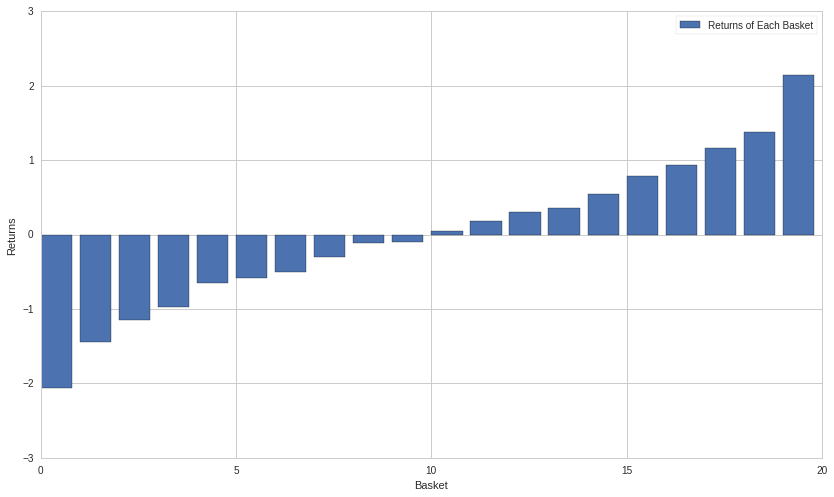

In [4]:
# Rank the equities
ranked_data = data.sort('Factor Value')

# Compute the returns of each basket
# Baskets of size 500, so we create an empty array of shape (10000/500)
number_of_baskets = 10000/500
basket_returns = np.zeros(number_of_baskets)

for i in range(number_of_baskets):
    start = i * 500
    end = i * 500 + 500 
    basket_returns[i] = ranked_data[start:end]['Returns'].mean()

# Plot the returns of each basket
plt.bar(range(number_of_baskets), basket_returns)
plt.ylabel('Returns')
plt.xlabel('Basket')
plt.legend(['Returns of Each Basket']);

Let's compute the returns if we go long the top basket and short the bottom basket.

In [5]:
basket_returns[number_of_baskets-1] - basket_returns[0]

4.2069451632105768

###Market Neutrality is Built-In

The nice thing about making money based on the spread of the ranking is that it is unaffected by what the market does.

In [6]:
# We'll generate a random factor
current_factor_values = np.random.normal(0, 1, 10000)
equity_names = ['Equity ' + str(x) for x in range(10000)]
# Put it into a dataframe
factor_data = pd.Series(current_factor_values, index = equity_names)
factor_data = pd.DataFrame(factor_data, columns=['Factor Value'])

# Now let's say our future returns are dependent on our factor values
future_returns = -10 + current_factor_values + np.random.normal(0, 1, 10000)

returns_data = pd.Series(future_returns, index=equity_names)
returns_data = pd.DataFrame(returns_data, columns=['Returns'])
# Put both the factor values and returns into one dataframe
data = returns_data.join(factor_data)

# Rank the equities
ranked_data = data.sort('Factor Value')

# Compute the returns of each basket
# Baskets of size 500, so we create an empty array of shape (10000/500
number_of_baskets = 10000/500
basket_returns = np.zeros(number_of_baskets)

for i in range(number_of_baskets):
    start = i * 500
    end = i * 500 + 500 
    basket_returns[i] = ranked_data[start:end]['Returns'].mean()

basket_returns[number_of_baskets-1] - basket_returns[0]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


4.2823147737388876

##Choice and Evaluation of a Ranking Scheme

The ranking scheme is where a long-short equity strategy gets its edge, and is the most crucial component. Choosing a good ranking scheme is the entire trick, and there is no easy answer. A good starting point is to pick existing known techniques, and see if you can modify them slightly to get increased returns. More information on ranking scheme construction can be found in the notebooks listed below.

During research of your ranking scheme, it's important to determine whether or not your ranking scheme is actually predictive of future returns. This can be accomplished with spearman rank correlation

Information on construction and evaluation of ranking schemes is available in the following lectures:
* [Universe Selection](https://www.quantopian.com/lectures/universe-selection)
* [Spearman Rank Correlation](https://www.quantopian.com/lectures/spearman-rank-correlation)
* [Factor Analysis](https://www.quantopian.com/lectures/factor-analysis)

##Long-Short is a Modular Strategy

To execute a long-short equity, you effectively only have to determine the ranking scheme. Everything after that is mechanical. Once you have one long-short equity strategy, you can swap in different ranking schemes and leave everything else in place. It's a very convenient way to quickly iterate over ideas you have without having to worry about tweaking code every time.

The ranking schemes can come from pretty much any model as well. It doesn't have to be a value based factor model, it could be a machine learning technique that predicted returns one-month ahead and ranked based on that.

We will be releasing sample long-short algorithms to go along with this notebook. Please stay tuned for those.

##Additional Considerations

###Rebalancing Frequency

Every ranking system will be predictive of returns over a slightly different timeframe. A price-based mean reversion may be predictive over a few days, while a value-based factor model may be predictive over many months. It is important to determine the timeframe over which your model should be predictive, and statistically verify that before executing your strategy. You do want to overfit by trying to optimize the relabancing frequency, you will inevitably find one that is randomly better than others, but not necessary because of anything in your model.

Once you have determined the timeframe on which your ranking scheme is predictive, try to rebalance at about that frequency so you're taking full advantage of your models.


###Capital Capacity

Every strategy has a minimum and maximum amount of capital it can trade before it stops being profitable. We will be releasing a full notebook discussing these concepts, but in the meantime consider the following.

###Number of Equities Traded

####Transaction Costs

Trading many equities will result in high transaction costs. Say that you want to purchase $1000$ equities, you will incur thousands of dollars of costs per rebalance. Your capital base must be high enough that the transaction costs are a small percentage of the returns being generated by your strategy. Say that you are running $100,000$ dollars and making $1\%$ per month, then the $1000$ dollars of transaction fees per month would take up your all of returns. You would need to be running the strategy on millions of dollars for it to be profitable over $1000$ equities.

The minimum capacity is quite high as such, and dependent largely on the number of equities traded. However, the maximum capacity is also incredibly high, with long-short equity strategies capable of trading hundreds of millions of dollars without losing their edge. This is true because the strategy rebalances relatively infrequently, and the total dollar volume is divided by the number of equities traded. So if you turn over your entire portfolio of $100,000,000$ every month while running 1000 equities, you are only running $100,000$ dollar-volume per month through each equity, which isn't enough to be a significant market share for most securities.

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*